# Sentence Embedding
Riordan Callil 2021
Honours research
Developing an instruction understanding robot
Current design: Instruction understanding using sentence embedding. Sentence embedding network will be trained in two phases. (1) Trained as a sentence autoencoder. Using the translation encoder-decoder framework. I will train the network to reconstruct the initial instruction from the latent representation. (2) I will fine tune the networks latent representations by training a classifier that uses the latent space to predict instruction action. (3) (FUTURE) As an additional step I might train the sentence autoencoder to translate high level instructions to low level instructions and visa versa. 

# Utils

In [2]:
import time
import math

def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)
    plt.show()

# Dataset: ALFRED

In [3]:
import tqdm
import glob
import json
import string
import torchtext
from torchtext.data import get_tokenizer
from nltk.stem import WordNetLemmatizer

# Loading and Transforming the ALFRED dataset utilites

def load_next_alfred_data(ALFRED_JSON_PATTERN):
    """
     Get list of all instructions and their trajectories
     glob.glob gets all files and stores them. iglob makes an iterator.
     
    Paramaters:
        @alfred_json_pattern
        A string which represents the location of the data with glob style
        regex expressions to denote multiple subdirectories.
    """ 
    train_json_files = glob.glob(ALFRED_JSON_PATTERN)
    tokenizer = get_tokenizer("basic_english")
    wnl = WordNetLemmatizer()
    dataset = []
    
    def preprocess_sentence(sentence):
        sentence = tokenizer(sentence)
        sentence = filter(lambda x: not x in string.punctuation, sentence)
        sentence = [wnl.lemmatize(word) for word in sentence]
        return sentence
    
    # Yeild an alfred json
    for json_file_idx in tqdm.tqdm(range(len(train_json_files))):
        data = json.load(open(train_json_files[json_file_idx]))
        annotations = data['turk_annotations']['anns']
        actions = data['plan']['high_pddl']
        scene = data['scene']
        scene['task_id'] = data['task_id']
        
        instruction_actions = []
        for d in annotations:
            votes = d['votes']
            if all(votes): # WARNING: Limiting dataset based on votes
                trajectory = {'task_desc': [], 'instructions': []}
                trajectory['task_desc'] = preprocess_sentence(d['task_desc'])
                for i in range(len(d['high_descs'])):
                    sanitized_instruction = preprocess_sentence(d['high_descs'][i])
                    #sanitized_instruction = tokenizer(d['high_descs'][i])
                    #sanitized_instruction = filter(lambda x: not x in string.punctuation,sanitized_instruction)
                    #sanitized_instruction = [wnl.lemmatize(word) for word in sanitized_instruction]
                    instruction = {'instruction': sanitized_instruction, 
                                   'action': actions[i]['discrete_action']['action'],
                                   'argument_1': actions[i]['discrete_action']['args'][0] if 0 < len(actions[i]['discrete_action']['args']) else '<unk>', 
                                   'argument_2': actions[i]['discrete_action']['args'][1] if 1 < len(actions[i]['discrete_action']['args']) else '<unk>'}
                    trajectory['instructions'].append(instruction)
                instruction_actions.append(trajectory)

        if len(instruction_actions) > 0:
            dataset.append((instruction_actions, scene))
    return dataset

train_dataset = load_next_alfred_data("D:/Datasets/alfred/data/ALFRED_json_2.1.0/train/*/*/*.json")
eval_dataset = load_next_alfred_data("D:/Datasets/alfred/data/ALFRED_json_2.1.0/valid_unseen/*/*/*.json")

100%|███████████████████████████████████████████████████████████| 255/255 [00:02<00:00, 98.57it/s]


In [26]:
import json
import os

class Language:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {}
        self.n_words = 0
    
    def add_sentence(self, sentence):
        for word in sentence:
            self.add_word(word)
    
    def add_word(self, word):
        if word not in self.word2index: # Add word to langauge if unseen 
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    
    def word(self, index):
        return self.index2word.get(index)
    
    def index(self, word):
        return self.word2index.get(word)
    
    def dump(self, filename):
        obj = {
            'word2index' : self.word2index,
            'word2count' : self.word2count,
            'index2word' : self.index2word,
            'n_words' : self.n_words
        }
        with open(filename, 'w') as fp:
            json.dump(obj, fp)
    
    def load(self, filename):
        with open(filename, 'r') as fp:
            obj = json.load(fp)
            self.word2index = obj['word2index']
            self.word2count = obj['word2count']
            self.index2word = obj['index2word']
            self.n_words = obj['n_words']
    
    def reset_counts(self):
        self.word2count = dict.fromkeys(self.word2count, 0)

# Check if backup, pickled, langauge object exists
lang = Language()
if os.path.isfile('instruction_language.json'):
    lang.load('instruction_language.json')
    lang.reset_counts()

action_lang = Language()
if os.path.isfile('action_language.json'):
    action_lang.load('action_language.json')
    action_lang.reset_counts()


lang.add_sentence(["<SOS>", "<EOS>"])
action_lang.add_sentence(["<SOS>", "<EOS>"])

def add_dataset_to_language(lang, dataset):
    sentence_lengths = []
    # Add dataset to langauge object
    for task in tqdm.tqdm(dataset): 
        for trajectory in task[0]:
            lang.add_sentence(trajectory['task_desc'])
            sentence_lengths.append(len(trajectory['task_desc']))
            for instruction in trajectory['instructions']:
                instruction_text = instruction['instruction']
                instruction_action = instruction['action']
                instruction_arg_1 = instruction['argument_1']
                instruction_arg_2 = instruction['argument_2']
                if len(instruction_text) > 0:
                    lang.add_sentence(instruction_text)
                action_lang.add_word(instruction_action)
                if instruction_arg_1 != '<unk>':
                    lang.add_word(instruction_arg_1)
                if instruction_arg_2 != '<unk>':
                    lang.add_word(instruction_arg_2)
                
            sentence_lengths.append(len(instruction_text))
    return sentence_lengths

sentence_lengths = add_dataset_to_language(lang, train_dataset)
eval_sentence_lengths = add_dataset_to_language(lang, eval_dataset)
sentence_lengths.extend(eval_sentence_lengths)

print('average sentence length = %.2f words' % (sum(sentence_lengths) / len(sentence_lengths)))

# Pickle the language as a backup
lang.dump('instruction_language.json')
action_lang.dump('action_language.json')

print('vocab size =', lang.n_words)
print('most common words: ', sorted(lang.word2count.items(), key=lambda item: item[1], reverse=True)[:10])
print('most common actions: ', sorted(action_lang.word2count.items(), key=lambda item: item[1], reverse=True))

print(action_lang.word2index)

100%|████████████████████████████████████████████████████████| 254/254 [00:00<00:00, 12700.47it/s]


average sentence length = 9.84 words
vocab size = 1947
most common words:  [('the', 314034), ('to', 88329), ('turn', 65997), ('and', 60512), ('on', 51078), ('of', 50848), ('right', 40425), ('left', 39517), ('in', 33950), ('a', 30771)]
most common actions:  [('GotoLocation', 62568), ('PickupObject', 28419), ('PutObject', 26162), ('CoolObject', 2761), ('SliceObject', 2737), ('HeatObject', 2727), ('CleanObject', 2603), ('ToggleObject', 2166), ('<SOS>', 1), ('<EOS>', 1)]
{'<SOS>': 0, '<EOS>': 1, 'GotoLocation': 2, 'PickupObject': 3, 'ToggleObject': 4, 'PutObject': 5, 'SliceObject': 6, 'CleanObject': 7, 'CoolObject': 8, 'HeatObject': 9}


In [13]:
###### Train Cirriculum ######
train_reconstruction = [] # [any text, any text]
train_high_low_pairs = [] # [high level instruction, low level instruction] # Swap for variability
train_low_action_pairs = [] # [low level instruction, action]
train_low_argument_pairs = [] # [low level instructions, argument_1 argument_2]

# Add dataset to langauge object
for task in tqdm.tqdm(train_dataset):
    for trajectory in task[0]:
        train_reconstruction.append(trajectory['task_desc'])
        for instruction in trajectory['instructions']:
            instruction_text = instruction['instruction']
            instruction_action = instruction['action']
            instruction_arg_1 = instruction['argument_1']
            instruction_arg_2 = instruction['argument_2']
            instruction_args = []
            if len(instruction_text) > 0:
                train_reconstruction.append(instruction_text)
                train_high_low_pairs.append([trajectory['task_desc'], instruction_text])
                train_low_action_pairs.append([instruction_text, [instruction_action]])
            if instruction_arg_1 != '<unk>':
                if instruction_arg_1 == 'wineglass':
                    print(instruction_text,instruction_arg_1 )
                instruction_args.append(instruction_arg_1)
            if instruction_arg_2 != '<unk>':
                instruction_args.append(instruction_arg_2)
            if len(instruction_args) > 0:
                train_low_argument_pairs.append([instruction_text, instruction_args])

print('train reconstruction samples =', len(train_reconstruction))
print('train high -> low pairs =', len(train_high_low_pairs))
print('train low -> action pairs =', len(train_low_action_pairs))
print('train low -> argument pairs =', len(train_low_argument_pairs))

###### Eval Cirriculum ######
eval_reconstruction = [] # [any text, any text]
eval_high_low_pairs = [] # [high level instruction, low level instruction] # Swap for variability
eval_low_action_pairs = [] # [low level instruction, action]
eval_low_argument_pairs = [] # [low level instructions, argument_1 argument_2]

# Add dataset to langauge object
for task in tqdm.tqdm(eval_dataset):
    for trajectory in task[0]:
        eval_reconstruction.append(trajectory['task_desc'])
        for instruction in trajectory['instructions']:
            instruction_text = instruction['instruction']
            instruction_action = instruction['action']
            instruction_arg_1 = instruction['argument_1']
            instruction_arg_2 = instruction['argument_2']
            instruction_args = []
            if len(instruction_text) > 0:
                eval_reconstruction.append(instruction_text)
                eval_high_low_pairs.append([trajectory['task_desc'], instruction_text])
                eval_low_action_pairs.append([instruction_text, [instruction_action]])
            if instruction_arg_1 != '<unk>':
                if instruction_arg_1 == 'wineglass':
                    print(instruction_text,instruction_arg_1 )
                instruction_args.append(instruction_arg_1)
            if instruction_arg_2 != '<unk>':
                instruction_args.append(instruction_arg_2)
            if len(instruction_args) > 0:
                eval_low_argument_pairs.append([instruction_text, instruction_args])

print('eval reconstruction samples =', len(eval_reconstruction))
print('eval high -> low pairs =', len(eval_high_low_pairs))
print('eval low -> action pairs =', len(eval_low_action_pairs))
print('eval low -> argument pairs =', len(eval_low_argument_pairs))

import torch
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device: {}'.format(device))
print('sample =', random.choice(train_high_low_pairs))

# Prepare data for tensor representation
def indices_from_sentence(lang, sentence):
    return [lang.index(word) for word in sentence]

def tensor_from_sentence(lang, sentence):
    indices = indices_from_sentence(lang, sentence)
    indices.append(lang.index('<EOS>'))
    return torch.tensor(indices, dtype=torch.long, device=device).view(-1,1)

def tensors_from_pair(input_lang, output_lang, pair):
    input_tensor = tensor_from_sentence(input_lang, pair[0])
    target_tensor = tensor_from_sentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

rpair = random.choice(train_low_action_pairs)
print(rpair)
print(tensors_from_pair(lang, action_lang, rpair))

100%|████████████████████████████████████████████████████████| 254/254 [00:00<00:00, 36288.34it/s]


train reconstruction samples = 144336
train high -> low pairs = 125571
train low -> action pairs = 125571
train low -> argument pairs = 125571
eval reconstruction samples = 5304
eval high -> low pairs = 4572
eval low -> action pairs = 4572
eval low -> argument pairs = 4572
using device: cuda
sample = [['put', 'a', 'clean', 'rag', 'in', 'the', 'tub'], ['put', 'the', 'rag', 'in', 'the', 'tub']]
[['pick', 'up', 'the', 'bottle', 'of', 'soap', 'that', 'is', 'sitting', 'on', 'the', 'side', 'of', 'the', 'bathtub'], ['PickupObject']]
(tensor([[  4],
        [  5],
        [  6],
        [398],
        [ 29],
        [803],
        [ 43],
        [ 44],
        [ 60],
        [ 11],
        [  6],
        [ 32],
        [ 29],
        [  6],
        [811],
        [  3]], device='cuda:0'), tensor([[5],
        [3]], device='cuda:0'))


# Model

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

MAX_LENGTH = 10

# Sourced from Pytorch Tutorial: Seq2Seq Translation Tutorial
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Train

updates:  54434
0m 1s (- 10m 37s) (100 0%) 0.0948
0m 2s (- 9m 30s) (200 0%) 0.0089
0m 3s (- 9m 7s) (300 0%) 0.0126
0m 3s (- 8m 56s) (400 0%) 0.1495
0m 4s (- 8m 48s) (500 0%) 0.0075
0m 5s (- 8m 39s) (600 1%) 0.0063
0m 6s (- 8m 36s) (700 1%) 0.0023
0m 7s (- 8m 32s) (800 1%) 0.0011
0m 8s (- 8m 28s) (900 1%) 0.0016
0m 9s (- 8m 25s) (1000 1%) 0.0028
0m 10s (- 8m 23s) (1100 2%) 0.0026
0m 11s (- 8m 20s) (1200 2%) 0.0010
0m 12s (- 8m 18s) (1300 2%) 0.0853
0m 13s (- 8m 16s) (1400 2%) 0.0187
0m 14s (- 8m 14s) (1500 2%) 0.0010
0m 14s (- 8m 12s) (1600 2%) 0.0018
0m 15s (- 8m 10s) (1700 3%) 0.0416
0m 16s (- 8m 6s) (1800 3%) 0.0012
0m 17s (- 8m 4s) (1900 3%) 0.0187
0m 18s (- 8m 2s) (2000 3%) 0.0555
0m 19s (- 8m 1s) (2100 3%) 0.0018
0m 20s (- 7m 59s) (2200 4%) 0.0022
0m 21s (- 7m 58s) (2300 4%) 0.0087
0m 22s (- 7m 57s) (2400 4%) 0.0022
0m 22s (- 7m 56s) (2500 4%) 0.0031
0m 23s (- 7m 55s) (2600 4%) 0.0051
0m 24s (- 7m 53s) (2700 4%) 0.0010
0m 25s (- 7m 52s) (2800 5%) 0.0017
0m 26s (- 7m 50s) (2900 5%)

3m 39s (- 5m 2s) (22900 42%) 0.0500
3m 40s (- 5m 1s) (23000 42%) 0.0025
3m 41s (- 5m 0s) (23100 42%) 0.0026
3m 42s (- 4m 59s) (23200 42%) 0.0190
3m 43s (- 4m 58s) (23300 42%) 0.0053
3m 44s (- 4m 57s) (23400 42%) 0.0844
3m 45s (- 4m 56s) (23500 43%) 0.1887
3m 46s (- 4m 55s) (23600 43%) 0.0070
3m 47s (- 4m 54s) (23700 43%) 0.1313
3m 48s (- 4m 53s) (23800 43%) 0.0217
3m 49s (- 4m 52s) (23900 43%) 0.0199
3m 50s (- 4m 51s) (24000 44%) 0.0388
3m 51s (- 4m 50s) (24100 44%) 0.0146
3m 52s (- 4m 49s) (24200 44%) 0.0927
3m 53s (- 4m 49s) (24300 44%) 0.0034
3m 54s (- 4m 48s) (24400 44%) 0.0189
3m 55s (- 4m 47s) (24500 45%) 0.0056
3m 55s (- 4m 46s) (24600 45%) 0.0025
3m 56s (- 4m 45s) (24700 45%) 0.0326
3m 57s (- 4m 44s) (24800 45%) 0.0647
3m 58s (- 4m 43s) (24900 45%) 0.0058
3m 59s (- 4m 42s) (25000 45%) 0.0049
4m 0s (- 4m 41s) (25100 46%) 0.0130
4m 1s (- 4m 40s) (25200 46%) 0.0414
4m 2s (- 4m 39s) (25300 46%) 0.0462
4m 3s (- 4m 38s) (25400 46%) 0.0420
4m 4s (- 4m 37s) (25500 46%) 0.0161
4m 5s (- 

7m 17s (- 1m 28s) (45300 83%) 0.0034
7m 18s (- 1m 27s) (45400 83%) 0.0093
7m 19s (- 1m 26s) (45500 83%) 0.0016
7m 20s (- 1m 25s) (45600 83%) 0.0486
7m 21s (- 1m 24s) (45700 83%) 0.0050
7m 22s (- 1m 23s) (45800 84%) 0.0036
7m 23s (- 1m 22s) (45900 84%) 0.0021
7m 24s (- 1m 21s) (46000 84%) 0.0012
7m 25s (- 1m 20s) (46100 84%) 0.0010
7m 26s (- 1m 19s) (46200 84%) 0.0007
7m 27s (- 1m 18s) (46300 85%) 0.0011
7m 28s (- 1m 17s) (46400 85%) 0.1279
7m 29s (- 1m 16s) (46500 85%) 0.0394
7m 30s (- 1m 15s) (46600 85%) 0.0044
7m 31s (- 1m 14s) (46700 85%) 0.0013
7m 32s (- 1m 13s) (46800 85%) 0.0897
7m 33s (- 1m 12s) (46900 86%) 0.0022
7m 34s (- 1m 11s) (47000 86%) 0.0017
7m 35s (- 1m 10s) (47100 86%) 0.0222
7m 36s (- 1m 9s) (47200 86%) 0.0017
7m 37s (- 1m 8s) (47300 86%) 0.0030
7m 38s (- 1m 7s) (47400 87%) 0.0039
7m 39s (- 1m 7s) (47500 87%) 0.0020
7m 40s (- 1m 6s) (47600 87%) 0.0030
7m 41s (- 1m 5s) (47700 87%) 0.0059
7m 41s (- 1m 4s) (47800 87%) 0.0017
7m 42s (- 1m 3s) (47900 87%) 0.0017
7m 43s (-

<Figure size 432x288 with 0 Axes>

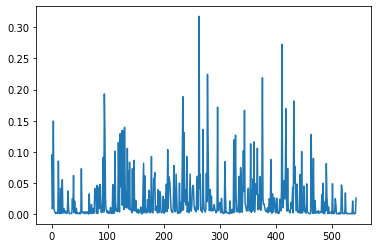

In [33]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[lang.index('<SOS>')]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == lang.index('<EOS>'):
                break

    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

hidden_size = 256
learning_rate = 0.01
epochs = 1
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, action_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('decoder.pt'):
    decoder.load_state_dict(torch.load('decoder.pt'))


start = time.time()
plot_every = 100
plot_losses = []
print_every = 100
print_loss_total = 0  # Reset every print_every
plot_loss_total = 0  # Reset every plot_every
update = 0 # Counts updates

encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
training_pairs = [sample for sample in train_low_action_pairs if len(sample[0]) < MAX_LENGTH and len(sample[1]) < MAX_LENGTH]
update_count = len(training_pairs) * epochs
print('updates: ', update_count)

criterion = nn.NLLLoss()

for epoch in range(epochs):
    for batch in training_pairs:
        update += 1
        training_pair = batch
        input_tensor = tensor_from_sentence(lang, training_pair[0])
        target_tensor = tensor_from_sentence(action_lang, training_pair[1])

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if update % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, update / update_count),
                                         update, (update / update_count) * 100, print_loss_avg))

        if update % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        
    # Save model after every epoch
    torch.save(encoder.state_dict(), 'encoder.pt')
    torch.save(decoder.state_dict(), 'decoder.pt')

show_plot(plot_losses)

# Eval

In [34]:
def evaluate(encoder, decoder, sentence, encoder_lang, decoder_lang, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(encoder_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[lang.index('<SOS>')]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == lang.index('<EOS>'):
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(decoder_lang.word(topi.item()))

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

hidden_size = 256
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, action_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('decoder.pt'):
    decoder.load_state_dict(torch.load('decoder.pt'))

eval_pairs = [sample for sample in eval_low_action_pairs if len(sample[0]) < MAX_LENGTH and len(sample[1]) < MAX_LENGTH]
results = []
print(f"samples: {len(eval_pairs)}")
for sample in eval_pairs:
    output = evaluate(encoder, decoder, sample[0], lang, action_lang)
    print(f"{' '.join(sample[0])} ({sample[1][0]}) -> {output[0]} ({output[0][0] == sample[1][0]})")
    results.append(output[0][0] == sample[1][0])

samples: 1939
turn to the left and face the desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the clock that is on the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn left then face the desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the alarm clock on the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn on the lamp (ToggleObject) -> ['PutObject', '<EOS>'] (False)
pick up the clock on the desk top (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn on the lamp (ToggleObject) -> ['PutObject', '<EOS>'] (False)
walk to face right side of desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up red and grey bottle from desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
walk to desk on right side of room (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn on lamp on the desk (ToggleObject) -> ['PutObject', '<EOS>'] (False)
use the metal box to turn on the lamp (ToggleObject) -> ['SliceObject', '<EOS>'] (False)
pick u

turn on the lamp (ToggleObject) -> ['PutObject', '<EOS>'] (False)
pick up the open box from the bottom shelf (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn on the light (ToggleObject) -> ['PutObject', '<EOS>'] (False)
turn on the lamp that is to your left (ToggleObject) -> ['PutObject', '<EOS>'] (False)
walk forward turn right to face the desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the cd that is on the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn the lamp on (ToggleObject) -> ['PutObject', '<EOS>'] (False)
walk to the right side of the desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
grab the cd from the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
locate the lamp on the desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn on the lamp (ToggleObject) -> ['PutObject', '<EOS>'] (False)
pick up the disc on the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn right and then turn back to the desk (GotoLocatio

turn the lamp on (ToggleObject) -> ['PutObject', '<EOS>'] (False)
turn on the lamp (ToggleObject) -> ['PutObject', '<EOS>'] (False)
turn to the left and walk to the sofa (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the newspaper from the sofa (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn on the lamp (ToggleObject) -> ['PutObject', '<EOS>'] (False)
pick up the newspaper on top of the sofa (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn on the lamp (ToggleObject) -> ['PutObject', '<EOS>'] (False)
pick up the newspaper from the sofa (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn on the floor lamp (ToggleObject) -> ['PutObject', '<EOS>'] (False)
turn right and head towards the cupboard (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
open the cupboard and take out the newspaper (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn left towards the standing light (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn on the standing light (Toggl

put the mug on the desk (PutObject) -> ['PutObject', '<EOS>'] (True)
walk to the side of the computer desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the cup on the edge of the desk (PutObject) -> ['PutObject', '<EOS>'] (True)
go to the left end of the desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the cup from the shelf (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn to the right (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
head to the desk in the corner (PickupObject) -> ['GotoLocation', '<EOS>'] (False)
take the pencil from the desk (GotoLocation) -> ['PickupObject', '<EOS>'] (False)
turn around twice put the pencil on the desk (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the white pencil on the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around in a circle (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the pencil that is on the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn right head to

walk to the shelf behind you on your right (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the vase in the safe (PutObject) -> ['PutObject', '<EOS>'] (True)
grab the golden object from the shelf (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn to the right to face the safe (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the golden object into the safe (PutObject) -> ['PutObject', '<EOS>'] (True)
go to the chest of drawer ahead of you (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the brown banded watch (PickupObject) -> ['PickupObject', '<EOS>'] (True)
take the watch across the room toward the safe (GotoLocation) -> ['PickupObject', '<EOS>'] (False)
turn right then turn left towards the dresser (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the watch from the dresser (PickupObject) -> ['PickupObject', '<EOS>'] (True)
place the watch in the safe box (PutObject) -> ['PutObject', '<EOS>'] (True)
turn right walk to the cabinet (GotoLocation)

pick up the brown ball from the counter top (PickupObject) -> ['PickupObject', '<EOS>'] (True)
look up to the counter top (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn to the wooden shelf on our right (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the tan bowl on the third shelf (PickupObject) -> ['PickupObject', '<EOS>'] (True)
bring the bowl up to the counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the egg in the bowl on the counter (PutObject) -> ['PutObject', '<EOS>'] (True)
step closer to the cabinet in front of you (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the egg in the bowl on the counter (PutObject) -> ['PutObject', '<EOS>'] (True)
put the egg in the bowl (PutObject) -> ['PutObject', '<EOS>'] (True)
grab a fork off of the kitchen counter there (PickupObject) -> ['PickupObject', '<EOS>'] (True)
grab the cup up out of the fridge (PickupObject) -> ['PickupObject', '<EOS>'] (True)
place the cup down on the kitchen counter (PutObj

put the transparent plate in the book shelf (PutObject) -> ['PutObject', '<EOS>'] (True)
go to the desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the pencil from the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
re-approach the desk where the bowl is (GotoLocation) -> ['PutObject', '<EOS>'] (False)
put the pencil in the bowl (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the bowl with the pencil (PickupObject) -> ['PickupObject', '<EOS>'] (True)
pick up the pencil from the book shelf (PickupObject) -> ['PickupObject', '<EOS>'] (True)
pick up the bowl from the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
put the bowl on top of the book shelf (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the pencil from the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
put the pencil in the bowl on the desk (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the bowl from the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
put the bowl

put the washcloth in the cabinet below the sink (PutObject) -> ['PutObject', '<EOS>'] (True)
turn to your right and walk to the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the cloth rag from the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
move back slightly from the counter top (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn around walk to the vanity on the right (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn right turn left to the counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn around turn around (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn left and face the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the green cloth in the sink (GotoLocation) -> ['PutObject', '<EOS>'] (False)
rinse the green cloth in the sink (CleanObject) -> ['PutObject', '<EOS>'] (False)
back up from the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the cloth back in the cabinet (PutObject) -> ['PutObjec

put the lettuce in the trash bin (PutObject) -> ['PutObject', '<EOS>'] (True)
go to the kitchen island (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up a butterknife (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around to the counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
cut the lettuce (SliceObject) -> ['SliceObject', '<EOS>'] (True)
go to the middle of the counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the butterknife down (PutObject) -> ['PutObject', '<EOS>'] (True)
go to the left part of the counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up a lettuce piece (PickupObject) -> ['PickupObject', '<EOS>'] (True)
go to the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
wash the lettuce (CleanObject) -> ['HeatObject', '<EOS>'] (False)
go to the black bin (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the lettuce in the bin (PutObject) -> ['PutObject', '<EOS>'] (True)
turn left move to in front of the refrige

pick up the soap bar from the bathroom counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn to the right and go to the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the bar of soap from the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
wet the soap with water (CleanObject) -> ['GotoLocation', '<EOS>'] (False)
put the soap back on the counter (PutObject) -> ['PutObject', '<EOS>'] (True)
go forward and to the sink on your right (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the soap (PickupObject) -> ['PickupObject', '<EOS>'] (True)
move slightly to the left (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the soap on the counter (PutObject) -> ['PutObject', '<EOS>'] (True)
wash the soap inside of the sink (CleanObject) -> ['PutObject', '<EOS>'] (False)
move to the counter in between the two sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the soap from the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True

turn left and go to the fridge (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
chill the egg and pick it up again (CoolObject) -> ['HeatObject', '<EOS>'] (False)
put the egg in the sink (PutObject) -> ['PutObject', '<EOS>'] (True)
place the cold egg in the sink (PutObject) -> ['PutObject', '<EOS>'] (True)
take the egg from in the sink (PickupObject) -> ['PickupObject', '<EOS>'] (True)
go to the fridge behind you (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
chill the egg inside of the fridge (CoolObject) -> ['PutObject', '<EOS>'] (False)
return to the sink behind you (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the egg from the sink (PickupObject) -> ['PickupObject', '<EOS>'] (True)
place the egg in the sink (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the egg from in the sink (PickupObject) -> ['PickupObject', '<EOS>'] (True)
put the egg back in the sink (PutObject) -> ['PutObject', '<EOS>'] (True)
move across the kitchen to the refrigerator (GotoLocation

pick up a lettuce slice from the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around go forward a bit turn left (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the lettuce in the basket (PutObject) -> ['PutObject', '<EOS>'] (True)
turn left and walk to the fridge (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
take a step right (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
take a small step to your right (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
take out the coffee mug in the cabinet (PickupObject) -> ['PickupObject', '<EOS>'] (True)
pick up the white coffee mug from the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
carry the mug to the refrigerator (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place mug in coffee maker on top of counter (PutObject) -> ['PutObject', '<EOS>'] (True)
turn to your left then head to the fridge (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the mug on the coffee maker (PutObject) -> ['PutO

walk to face fridge (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
chill and remove tomato slice from fridge (CoolObject) -> ['PickupObject', '<EOS>'] (False)
walk to face counter with statue (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put tomato slice on counter (PutObject) -> ['PutObject', '<EOS>'] (True)
move forward to the table by the toaster (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the knife from the table (PickupObject) -> ['PickupObject', '<EOS>'] (True)
move right to the table (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
slice the tomato on the table (SliceObject) -> ['SliceObject', '<EOS>'] (True)
drop the knife on the table (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up a slice of the tomato (PickupObject) -> ['PickupObject', '<EOS>'] (True)
move left to the fridge (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
move right to the table (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
drop the slice on the table (PutObject) -> ['P

turn around and go back to the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the green apple out of the sink (PickupObject) -> ['PickupObject', '<EOS>'] (True)
cut the apple in the sink into three chunk (SliceObject) -> ['SliceObject', '<EOS>'] (True)
pick up one of the chunk of apple (PickupObject) -> ['PickupObject', '<EOS>'] (True)
put the chunk of apple on the counter please (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the gray knife on the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
cut the green apple inside the sink (SliceObject) -> ['SliceObject', '<EOS>'] (True)
place the gray knife inside the sink (PutObject) -> ['PutObject', '<EOS>'] (True)
put the apple slice on to the counter (PutObject) -> ['PutObject', '<EOS>'] (True)
put the knife in the garbage can (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the knife on the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
cut the apple on the counter into three piece (SliceOb

pick up the bread on the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
step to the right and face the counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the knife on the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
cut the bread on the counter into slice (SliceObject) -> ['SliceObject', '<EOS>'] (True)
pick up a slice of bread on the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
place the cup back into the cabinet (PutObject) -> ['PutObject', '<EOS>'] (True)
go right and stand in front of the microwave (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn right and walk to the stove (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
move to the front of the stove (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
heat the glass in the microwave above the stove (HeatObject) -> ['HeatObject', '<EOS>'] (True)
put the glass away in the cabinet (PutObject) -> ['PutObject', '<EOS>'] (True)
warm the cup in the microwave above the stove

turn left and step forward to face the shelf (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the knife on the shelf (PutObject) -> ['PutObject', '<EOS>'] (True)
turn right to face the fridge (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up a slice of potato in the fridge (PickupObject) -> ['PickupObject', '<EOS>'] (True)
place the potato slice in the fridge (PutObject) -> ['PutObject', '<EOS>'] (True)
go back across the room to the fridge (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the knife on the top shelf (PutObject) -> ['PutObject', '<EOS>'] (True)
go back to the fridge (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up a slice of potato in the fridge (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn right and go to the microwave (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn left and go back to the fridge (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
grab the knife off of the counter (PickupObject) -> ['PickupObject', '<EOS

pick up the knife on the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
cut a slice out of the tomato (SliceObject) -> ['SliceObject', '<EOS>'] (True)
place tomato in the microwave (GotoLocation) -> ['PutObject', '<EOS>'] (False)
turn around and go back to the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the tomato in the sink (PutObject) -> ['PutObject', '<EOS>'] (True)
turn around and go to the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
cut the tomato in the sink into slice (SliceObject) -> ['SliceObject', '<EOS>'] (True)
place the knife in the sink (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up one of the tomato slice (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn back around to the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the tomato slice in the sink (PutObject) -> ['PutObject', '<EOS>'] (True)
take the apple closer to you from the sink (PickupObject) -> ['PickupObject', '<EOS>'] (True)
take the apple fro

turn around to face the counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
go to the desk directly behind you (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the disc in the safe (PutObject) -> ['PutObject', '<EOS>'] (True)
return to the desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
carry the disc to the corner safe (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the cd from the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
place the cd in the vault (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the cd from the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
place the cd in the vault and close (PutObject) -> ['PutObject', '<EOS>'] (True)
move to the desk closest to the widow (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the cd from the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
place the cd inside and close the door (PutObject) -> ['PutObject', '<EOS>'] (True)
move to the desk closest to the widow (Go

pick up the left pillow on the chair (PickupObject) -> ['PickupObject', '<EOS>'] (True)
pick up the pillow on the chair (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn left and walk over to the blue chair (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the bar of soap from the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn left then head to the toilet tank (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the soap on the tank (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn left head to the sink counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the soap on the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn to face the cabinet under the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
walk to the left-hand sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn to face the cabinet under the right sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
move further back from the counter (Got

put empty toilet paper roll in cabinet (PutObject) -> ['PutObject', '<EOS>'] (True)


In [35]:
print(f"Success rate: {sum(results) / len(results)}")

Success rate: 0.8932439401753481
